<a href="https://colab.research.google.com/github/Guilleblaanco/Angular-web/blob/main/Biofisica1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Trabajo Biofísica.

Guillermo Eiroa Blanco, Martín Diz Lindahl.

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
#Cargar los .csv
from google.colab import drive
drive.mount('/content/drive')
#Importar Pandas
import pandas as pd
Datos=pd.read_csv('/content/drive/MyDrive/BioFisica1/DatosTiroteos_incident.csv',sep=None, engine='python')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
#Numpy y librerías que usó Mario para la red neuronal
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from sklearn.preprocessing import LabelEncoder

La idea de momento es diseñar una red neuronal que con los siguientes inputs:


1.   Tipo de tiroteo (espontáneo,con objetivos)
2.   Planificado previamente (sí/no)
1.   Víctima de bullying(sí/no)
2.   Vícitma o testigo de violencia doméstica (sí/no)
1.   Seguridad(detector de metales/guardias/guardias armados/ninguna)

In [65]:
#Modificamos los datos para rellenar los espacios vacíos de la base de datos, para la sección de seguridad los espacios en blanco serán designados como 'sin seguridad' y para las demás categorías serán 'unknown'
Datos['Security_Screening'] = Datos['Security_Screening'].fillna('No security')
Datos['GV_Type'] = Datos['GV_Type'].fillna('Unknown')
Datos['Preplanned'] = Datos['Preplanned'].fillna('Unknown')
Datos['Domestic_Violence'] = Datos['Domestic_Violence'].fillna('Unknown')
Datos['Bullied'] = Datos['Bullied'].fillna('Unknown')

In [66]:
#Codificamos nuestros datos tipo string en datos númericos para que los pueda procesar la red neuronal
Security_data=[]
Type_data=[]
Preplanned_data=[]
Domestic_data=[]
Bullied_data=[]


Nuestro modelo tratará de predecir si hubo heridos y muertos.

Decidimos filtrar las categorías de la base de datos, quedándonos únicamente con las siguientes: state, school level, during class time, GV_type, targets, accomplice, bullied, domestic violence, gang related, active shotter FBI, preplanned, shot fired, security screening. Otras categorías de datos como el ZIP o el estado nos parecían irrelevantes o demasiado concretas, llevándonos posiblemente a una situación de overfitting.

En la siguiente celda de código creamos las variables objetivo:


In [67]:
# Convertir víctimas a número, tratando errores como NaN y rellenando con 0
Datos['Victims_Killed'] = pd.to_numeric(Datos['Victims_Killed'], errors='coerce').fillna(0)
Datos['Victims_Wounded'] = pd.to_numeric(Datos['Victims_Wounded'], errors='coerce').fillna(0)

# Crear las columnas objetivo (target)
Datos['Hubo_Muertos'] = Datos['Victims_Killed'].apply(lambda x: 'Si' if x > 0 else 'No')
Datos['Hubo_Heridos'] = Datos['Victims_Wounded'].apply(lambda x: 'Si' if x > 0 else 'No')

# Revisar las nuevas columnas
print("Columnas 'Hubo_Muertos' y 'Hubo_Heridos' creadas.")
Datos[['Victims_Killed', 'Hubo_Muertos', 'Victims_Wounded', 'Hubo_Heridos']].head()

Columnas 'Hubo_Muertos' y 'Hubo_Heridos' creadas.


,Victims_Killed,Hubo_Muertos,Victims_Wounded,Hubo_Heridos
0,0.0,No,2.0,Si
1,0.0,No,1.0,Si
2,0.0,No,1.0,Si
3,0.0,No,1.0,Si
4,0.0,No,1.0,Si


Definimos la lista exacta de las 13 columnas de características (features) que quieres usar y las 2 de objetivo (targets) que acabamos de crear. Luego, filtramos el DataFrame.

In [68]:
# Lista de las 13 columnas de features (características)
columnas_features = [
    'State',
    'School_Level',
    'During_Classes',
    'GV_Type',
    'Targets',
    'Accomplice',
    'Bullied',
    'Domestic_Violence',
    'Gang_Related',
    'Active_Shooter_FBI',
    'Preplanned',
    'Shots_Fired',
    'Security_Screening'
]

# Columnas objetivo
columnas_target = ['Hubo_Muertos', 'Hubo_Heridos']

# Lista completa
columnas_finales = columnas_features + columnas_target

# Filtrar el DataFrame
Datos_filtrados = Datos[columnas_finales].copy()

print(f"DataFrame filtrado a {Datos_filtrados.shape[1]} columnas.")

DataFrame filtrado a 15 columnas.


Antes de codificar, debemos asegurarnos de que ninguna columna seleccionada tenga valores NaN. Iteramos por nuestras 13 columnas de features y rellenamos cualquier NaN restante con 'Unknown'.

In [69]:
# Iteramos por las columnas de features para rellenar los NaNs que queden
for col in columnas_features:
    if col in Datos_filtrados.columns:
        # Rellenamos cualquier NaN restante con 'Unknown'
        Datos_filtrados[col] = Datos_filtrados[col].fillna('Unknown')

print("Rellenado de NaNs completado para todas las features.")

Rellenado de NaNs completado para todas las features.


Este es el paso clave de "traducción". Convertimos todas las columnas (tanto features como targets) de texto ('Si', 'No', 'High', 'Middle', 'CA', 'TX', etc.) a números enteros que la red neuronal pueda entender.

In [70]:
# Crear una copia para la codificación
Datos_codificados = Datos_filtrados.copy()
encoders = {} # Para guardar los encoders por si los necesitamos

# Iterar por TODAS las columnas del DataFrame filtrado
for col in Datos_codificados.columns:
    # Crear un codificador nuevo para cada columna
    le = LabelEncoder()

    # "Aprender" y "Transformar" la columna a números
    # .astype(str) asegura que todo se trate como texto antes de codificar
    Datos_codificados[col] = le.fit_transform(Datos_codificados[col].astype(str))

    # Opcional: guardar el encoder
    encoders[col] = le

print("¡Codificación completada!")
Datos_codificados.head()

¡Codificación completada!


,State,School_Level,During_Classes,GV_Type,Targets,Accomplice,Bullied,Domestic_Violence,Gang_Related,Active_Shooter_FBI,Preplanned,Shots_Fired,Security_Screening,Hubo_Muertos,Hubo_Heridos
0,35,2,0,2,4,2,1,1,1,0,0,31,13,0,1
1,18,2,0,3,3,1,1,1,1,0,0,55,0,0,1
2,43,6,2,2,4,0,2,1,0,0,0,1,0,0,1
3,20,2,2,1,4,0,1,1,0,0,0,18,13,0,1
4,14,2,2,3,3,1,1,1,1,0,0,1,13,0,1


Finalmente, guardamos este DataFrame limpio y codificado en un nuevo archivo CSV. Este será el archivo que usemos para entrenar al modelo.

In [71]:
# Guardar el DataFrame final en un nuevo CSV
Datos_codificados.to_csv("datos_codificados.csv", index=False)

print("DataFrame final guardado como 'datos_codificados.csv'")

DataFrame final guardado como 'datos_codificados.csv'


Ya con los datos codificados debemos separarlos en dos clases para entrenar al modelo:

*   X (Features): Serán todas las columnas que usaremos para predecir (las 13 que seleccionamos).
*   y (Targets): Serán las columnas que queremos predecir (en nuestro caso, Hubo_Muertos y Hubo_Heridos).

Dado que tenemos dos objetivos, lo más sencillo es crear dos variables y separadas y entrenar un modelo para cada una.


In [72]:
# 1. Crear X (Features)
# Usamos .drop() para quitar las columnas que queremos predecir
X = Datos_codificados.drop(['Hubo_Muertos', 'Hubo_Heridos'], axis=1)

# 2. Crear y (Targets)
y_muertos = Datos_codificados['Hubo_Muertos']
y_heridos = Datos_codificados['Hubo_Heridos']

# Imprimimos la "forma" (shape) para verificar
print(f"Forma de X (features): {X.shape}")
print(f"Forma de y_muertos (target 1): {y_muertos.shape}")
print(f"Forma de y_heridos (target 2): {y_heridos.shape}")

print("\n--- Primeras filas de X ---")
print(X.head())

Forma de X (features): (3575, 13)
Forma de y_muertos (target 1): (3575,)
Forma de y_heridos (target 2): (3575,)

--- Primeras filas de X ---
   State  School_Level  During_Classes  GV_Type  Targets  Accomplice  Bullied  \
0     35             2               0        2        4           2        1   
1     18             2               0        3        3           1        1   
2     43             6               2        2        4           0        2   
3     20             2               2        1        4           0        1   
4     14             2               2        3        3           1        1   

   Domestic_Violence  Gang_Related  Active_Shooter_FBI  Preplanned  \
0                  1             1                   0           0   
1                  1             1                   0           0   
2                  1             0                   0           0   
3                  1             0                   0           0   
4                  1  

Ahora, dividiremos X e y en dos grupos:


1.   Datos de Entrenamiento (Train): La mayoría de los datos (normalmente 70%-80%). Usaremos esto para enseñarle al modelo.
2.   Datos de Prueba (Test): Los datos restantes (20%-30%). Usaremos esto para evaluar qué tan bien aprendió el modelo con datos que nunca ha visto.

Usaremos la función train_test_split de scikit-learn. Empecemos preparando el modelo para Hubo_Muertos.



In [73]:
from sklearn.model_selection import train_test_split

# Vamos a enfocarnos en el primer modelo: predecir Hubo_Muertos
# Dividimos X e y_muertos

# test_size=0.2 significa que el 20% de los datos se usarán para "test"
# random_state=42 es un número fijo para asegurar que la división sea reproducible

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_muertos,
    test_size=0.2,
    random_state=42
)

print(f"Datos listos para el modelo 'Hubo_Muertos':")
print(f" - X_train (features de entrenamiento): {X_train.shape[0]} filas")
print(f" - X_test (features de prueba): {X_test.shape[0]} filas")
print(f" - y_train (respuestas de entrenamiento): {y_train.shape[0]} filas")
print(f" - y_test (respuestas de prueba): {y_test.shape[0]} filas")

Datos listos para el modelo 'Hubo_Muertos':
 - X_train (features de entrenamiento): 2860 filas
 - X_test (features de prueba): 715 filas
 - y_train (respuestas de entrenamiento): 2860 filas
 - y_test (respuestas de prueba): 715 filas


Para empezar, escogemos un móodelo sólido como es el Random Forest, que no necesita normalizar los datos y no suele dar problemas de overfitting, para posteriormente comparar con otras opciones más complejas como las redes neuronales.

Vamos a importar el RandomForestClassifier. También importaremos las herramientas para evaluar qué tan bueno es nuestro modelo: accuracy_score (precisión) y classification_report (un reporte detallado con precisión, recall y F1-score).

In [74]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Crearemos una instancia del modelo. Usamos random_state=42 de nuevo para que el modelo sea reproducible.

Luego, lo entrenaremos (.fit()) usando nuestros datos de entrenamiento (X_train e y_train).

In [75]:
# Inicializar el modelo
# n_estimators=100 significa que construirá 100 "árboles de decisión"
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo con los datos de entrenamiento
print("Entrenando el modelo Random Forest para 'Hubo_Muertos'...")
modelo_rf.fit(X_train, y_train)

print("¡Entrenamiento completado!")

Entrenando el modelo Random Forest para 'Hubo_Muertos'...
¡Entrenamiento completado!


Este es el momento de la verdad. Usaremos el modelo entrenado para hacer predicciones (.predict()) sobre los datos de prueba (X_test), que el modelo nunca ha visto.

Luego, compararemos esas predicciones (y_pred) con las respuestas correctas (y_test) para ver qué tan bien lo hizo.

In [76]:
# 1. Hacer predicciones en el conjunto de prueba
y_pred = modelo_rf.predict(X_test)

# 2. Calcular la Precisión (Accuracy)
# (Qué porcentaje de predicciones acertó)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión (Accuracy) del modelo: {accuracy * 100:.2f}%")
print("-" * 50)

# 3. Mostrar el Reporte de Clasificación Detallado
# (Aquí veremos 'precision' y 'recall' para las clases 0 (No) y 1 (Si))
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=['No Hubo Muertos (0)', 'Si Hubo Muertos (1)']))

Precisión (Accuracy) del modelo: 80.28%
--------------------------------------------------
Reporte de Clasificación:
                     precision    recall  f1-score   support

No Hubo Muertos (0)       0.85      0.92      0.88       587
Si Hubo Muertos (1)       0.42      0.26      0.32       128

           accuracy                           0.80       715
          macro avg       0.63      0.59      0.60       715
       weighted avg       0.77      0.80      0.78       715



En la siguiente celda de código hacemos de forma compacta el mismo proceso que ya hicimos para predecir el número de muertos.

In [77]:
# (Usamos la misma X, pero la 'y' de heridos)
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(
    X,
    y_heridos,  # <-- La única diferencia
    test_size=0.2,
    random_state=42
)

print("\nEntrenando el modelo Random Forest para 'Hubo_Heridos'...")
modelo_rf_heridos = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_rf_heridos.fit(X_train_h, y_train_h)
print("¡Entrenamiento completado!")

y_pred_h = modelo_rf_heridos.predict(X_test_h)
accuracy_h = accuracy_score(y_test_h, y_pred_h)

print(f"\nPrecisión (Accuracy) del modelo 'Heridos': {accuracy_h * 100:.2f}%")
print("Reporte de Clasificación 'Heridos':")
print(classification_report(y_test_h, y_pred_h, target_names=['No Hubo Heridos (0)', 'Si Hubo Heridos (1)']))


Entrenando el modelo Random Forest para 'Hubo_Heridos'...
¡Entrenamiento completado!

Precisión (Accuracy) del modelo 'Heridos': 68.67%
Reporte de Clasificación 'Heridos':
                     precision    recall  f1-score   support

No Hubo Heridos (0)       0.71      0.79      0.75       421
Si Hubo Heridos (1)       0.64      0.54      0.59       294

           accuracy                           0.69       715
          macro avg       0.68      0.66      0.67       715
       weighted avg       0.68      0.69      0.68       715



A continuación, tenemos que valorar como de buenos son nuestros resultados. La "Precisión" (Accuracy) puede ser una métrica muy engañosa.

Si, por ejemplo, el 90% de los tiroteos no tuvieron muertos (clase 0) y solo el 10% sí tuvo (clase 1), un modelo perezoso podría simplemente predecir "No Hubo Muertos" el 100% del tiempo y obtendría un 90% de precisión, pero sería un modelo inútil.

Tenemos que comprobar si nuestras clases (0 y 1) están desbalanceadas. Usaremos los datos codificados antes del train_test_split para ver el balance general.

--- Balance de 'Hubo_Muertos' ---
Hubo_Muertos
0    0.801119
1    0.198881
Name: proportion, dtype: float64

--- Balance de 'Hubo_Heridos' ---
Hubo_Heridos
0    0.589371
1    0.410629
Name: proportion, dtype: float64


/tmp/ipython-input-421242072.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(['No (0)', 'Si (1)'])
/tmp/ipython-input-421242072.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(['No (0)', 'Si (1)'])


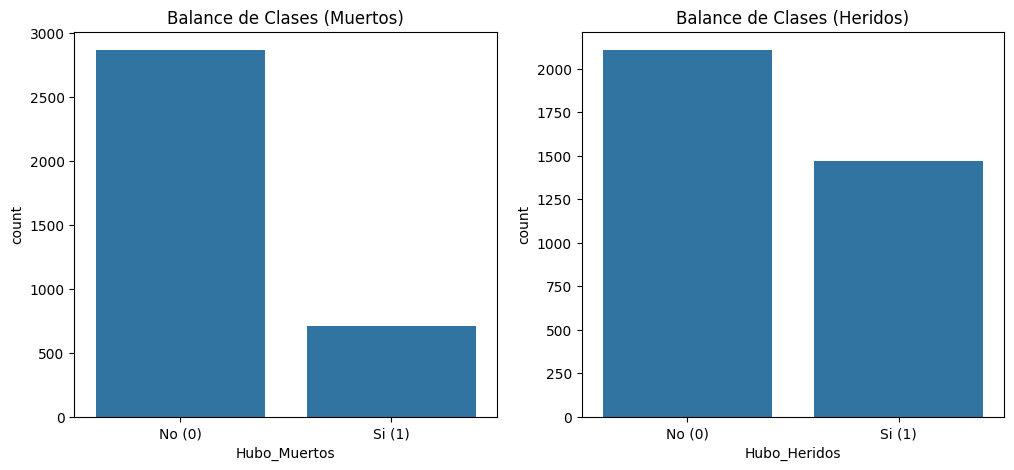

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Revisar balance de 'Hubo_Muertos'
print("--- Balance de 'Hubo_Muertos' ---")
print(Datos_codificados['Hubo_Muertos'].value_counts(normalize=True))

# 2. Revisar balance de 'Hubo_Heridos'
print("\n--- Balance de 'Hubo_Heridos' ---")
print(Datos_codificados['Hubo_Heridos'].value_counts(normalize=True))

# 3. Visualización
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(x='Hubo_Muertos', data=Datos_codificados, ax=ax[0])
ax[0].set_title('Balance de Clases (Muertos)')
ax[0].set_xticklabels(['No (0)', 'Si (1)'])

sns.countplot(x='Hubo_Heridos', data=Datos_codificados, ax=ax[1])
ax[1].set_title('Balance de Clases (Heridos)')
ax[1].set_xticklabels(['No (0)', 'Si (1)'])

plt.savefig("class_balance.png")

Observando las gráficas es evidente porqué obtenemos un resultado tan aparentemente "satisfactorio" en la predicción de los muertos comparado con el resultado en el número de heridos.

Nuestras sospechas se confirman y es que el modelo no está prediciendo prácticamente nada, el recall para SÍ HUBO MUERTOS es del 0.26, es decir, solo está encontrando 1/4 de los tiroteos donde SÍ HUBO MUERTOS.

La precisión del 80% es una ilusión. El modelo está "haciendo trampa" al predecir casi siempre "No" (la clase mayoritaria), y como el 80% de los datos son "No", acierta el 80% de las veces.

Para el caso de si hubo heridos el recall es un poco mejor pero teniendo en cuenta la precisión del modelo, en general los resultados son deficientes.

El Random Forest es un modelo de "caja blanca". Podemos preguntarle qué aprendió.

Vamos a ver cuáles de las 13 categorías (State, School_Level, Bullied, etc.) consideró más importantes para tomar sus decisiones.

--- Importancia de Features (Modelo 'Muertos') ---
               Feature  Importancia
0                State     0.287222
11         Shots_Fired     0.166501
1         School_Level     0.095023
4              Targets     0.080811
5           Accomplice     0.058201
8         Gang_Related     0.055381
12  Security_Screening     0.045625
9   Active_Shooter_FBI     0.044328
2       During_Classes     0.040657
6              Bullied     0.037060
7    Domestic_Violence     0.031220
3              GV_Type     0.029035
10          Preplanned     0.028938


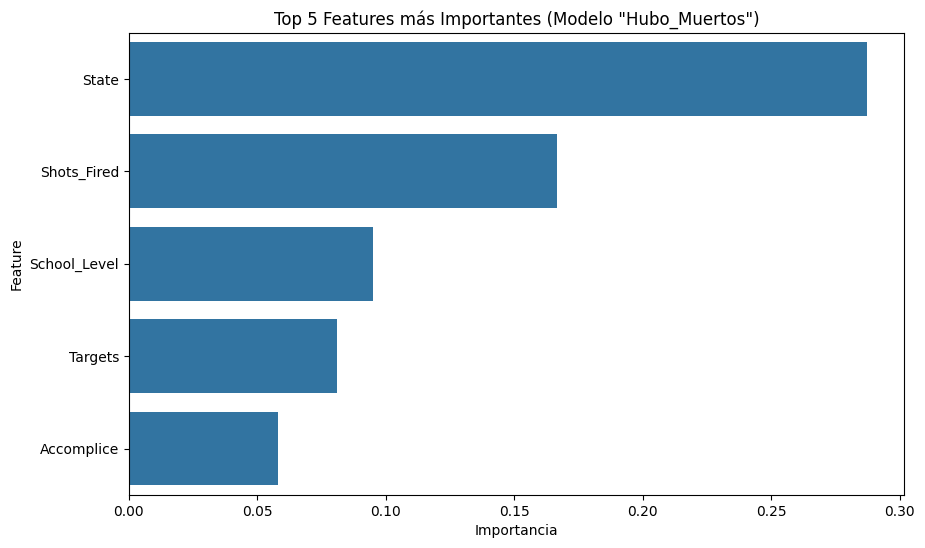

In [79]:
# Obtener las importancias
importancias = modelo_rf.feature_importances_
feature_names = X.columns

# Crear un DataFrame para verlo fácil
importancia_df = pd.DataFrame({
    'Feature': feature_names,
    'Importancia': importancias
})

# Ordenar de mayor a menor
importancia_df = importancia_df.sort_values(by='Importancia', ascending=False)

print("--- Importancia de Features (Modelo 'Muertos') ---")
print(importancia_df)

# Graficar las 5 más importantes
plt.figure(figsize=(10, 6))
sns.barplot(x='Importancia', y='Feature', data=importancia_df.head(5))
plt.title('Top 5 Features más Importantes (Modelo "Hubo_Muertos")')
plt.savefig("feature_importance.png")

Fijándonos en estos datos parece sospechoso que se le de tanta importancia al estado. Esto probablemente se deba a la alta cardinaldad de esa categoría. Estamos cayendo en un problema de overfitting que confunde al modelo, dejando de lado otras categorías intuitivamente más importantes como la planificación del delito.

En la siguiente celda haremos lo siguiente, re-entrenaremos al modelo corrigiendo el desbalance. Es posible que sacrifiquemos precisión pero deberíamos de mejorar el recall.

In [80]:
# (Asumiendo que X_train, X_test, y_train, y_test para 'Muertos' ya existen)

# 1. Inicializar el modelo CON class_weight
# Esto le dice al modelo que pese las clases inversamente a su frecuencia
modelo_rf_balanceado = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'  # <-- LA MAGIA ESTÁ AQUÍ
)

# 2. Entrenar
print("Entrenando modelo balanceado para 'Hubo_Muertos'...")
modelo_rf_balanceado.fit(X_train, y_train)
print("Entrenamiento completado.")

# 3. Evaluar
y_pred_bal = modelo_rf_balanceado.predict(X_test)
accuracy_bal = accuracy_score(y_test, y_pred_bal)

print(f"\nPrecisión (Accuracy) BALANCEADA: {accuracy_bal * 100:.2f}%")
print("-" * 50)
print("Reporte de Clasificación (BALANCEADO):")
print(classification_report(y_test, y_pred_bal, target_names=['No (0)', 'Si (1)']))

Entrenando modelo balanceado para 'Hubo_Muertos'...
Entrenamiento completado.

Precisión (Accuracy) BALANCEADA: 79.86%
--------------------------------------------------
Reporte de Clasificación (BALANCEADO):
              precision    recall  f1-score   support

      No (0)       0.85      0.92      0.88       587
      Si (1)       0.40      0.24      0.30       128

    accuracy                           0.80       715
   macro avg       0.62      0.58      0.59       715
weighted avg       0.77      0.80      0.78       715



El resultado obtenido es extremandamente interesante y es que es muy raro que el recall empeore tras haber balanceado. Ahora que sabemos que State está envenenando el modelo, y class_weight por sí solo no funciona, vamos a combinar las dos soluciones.

Entrenando modelo (Balanceado Y Sin State)...
Entrenamiento completado.

Precisión (Combo): 78.60%
Reporte de Clasificación (Combo: Balanceado + Sin State):
              precision    recall  f1-score   support

      No (0)       0.87      0.87      0.87       587
      Si (1)       0.41      0.42      0.41       128

    accuracy                           0.79       715
   macro avg       0.64      0.64      0.64       715
weighted avg       0.79      0.79      0.79       715

--------------------------------------------------

--- NUEVA Importancia de Features (Sin State) ---
               Feature  Importancia
10         Shots_Fired     0.227740
0         School_Level     0.157250
3              Targets     0.137711
4           Accomplice     0.076690
7         Gang_Related     0.070545
11  Security_Screening     0.065103
8   Active_Shooter_FBI     0.058918
1       During_Classes     0.054216
5              Bullied     0.042512
2              GV_Type     0.039649
9           Prepla

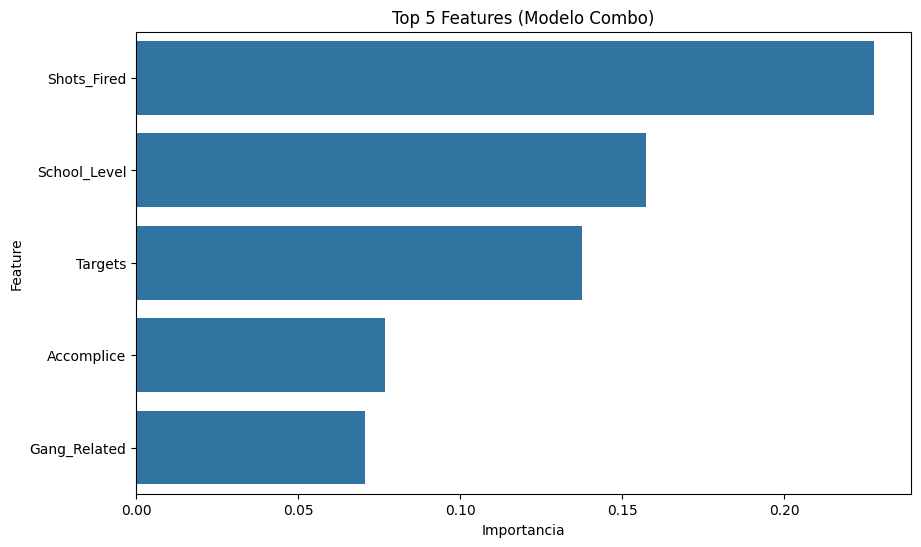

In [81]:
# 1. Crear copias de nuestros sets de datos SIN 'State'
X_train_sin_state = X_train.drop('State', axis=1)
X_test_sin_state = X_test.drop('State', axis=1)

# 2. Inicializar el modelo con AMBAS soluciones:
# class_weight='balanced' Y usando los datos sin 'State'
modelo_rf_combo = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced' # <-- Solución 1 (para el 80/20)
)

# 3. Entrenar con los datos SIN 'State' (Solución 2)
print("Entrenando modelo (Balanceado Y Sin State)...")
# Nota: usamos y_train (el original), no ha cambiado
modelo_rf_combo.fit(X_train_sin_state, y_train)
print("Entrenamiento completado.")

# 4. Evaluar
y_pred_combo = modelo_rf_combo.predict(X_test_sin_state)
accuracy_combo = accuracy_score(y_test, y_pred_combo) # y_test es el mismo

print(f"\nPrecisión (Combo): {accuracy_combo * 100:.2f}%")
print("Reporte de Clasificación (Combo: Balanceado + Sin State):")
print(classification_report(y_test, y_pred_combo, target_names=['No (0)', 'Si (1)']))
print("-" * 50)

# 5. REVISAR FEATURE IMPORTANCE
# (Este es el momento de la verdad)

importancias_combo = modelo_rf_combo.feature_importances_
feature_names_combo = X_train_sin_state.columns # Nombres de features sin 'State'

importancia_df_combo = pd.DataFrame({
    'Feature': feature_names_combo,
    'Importancia': importancias_combo
})
importancia_df_combo = importancia_df_combo.sort_values(by='Importancia', ascending=False)

print("\n--- NUEVA Importancia de Features (Sin State) ---")
print(importancia_df_combo)

# Graficar las 5 más importantes
plt.figure(figsize=(10, 6))
sns.barplot(x='Importancia', y='Feature', data=importancia_df_combo.head(5))
plt.title('Top 5 Features (Modelo Combo)')
plt.savefig("feature_importance_combo.png")

Vemos como hemos podido mejorar notablemente el modelo aplicando estas dos soluciones. Aún así los resultados son muy mejorables. Es posible que el modelo se siga dejando llevar por categorías con alta cardinalidad, por lo que en vez de sacrificar más datos probablemente sea más adecuado pasar directamente a usar una red neuronal para ver si podemos mejorar nuestra capacidad predictiva.

Para esta sección, cambiaremos nuestro enfoque al modelo de Red Neuronal. El modelo usado será el Perceptrón Multicapa (MLP), también conocido como Red Neuronal Densa.

El objetivo es construir un solo modelo que realice una clasificación multi-etiqueta (multi-label): predecirá simultáneamente si hubo muertos (etiqueta 1) y si hubo heridos (etiqueta 2).

La arquitectura de nuestro MLP seguirá este esquema:

1.   Capa de Entrada (Input Layer): Tendrá 12 neuronas, una por cada feature o característica de nuestros datos (recordemos que eliminamos la columna State por ser problemática).

2. Capas Ocultas (Hidden Layers): Aquí es donde ocurre el verdadero "aprendizaje de características". En lugar de capas convolucionales (que buscan patrones en píxeles), usaremos una sucesión de capas densas (totalmente conectadas). Experimentaremos con su tamaño (p.ej., 256 o 128 neuronas) y usaremos técnicas modernas para mejorar el entrenamiento:


      *   BatchNormalization: Ayuda a estabilizar y acelerar el aprendizaje.
      *   Dropout: Desactiva aleatoriamente un porcentaje de neuronas durante el entrenamiento para prevenir el sobreajuste (evitar que el modelo "memorice" los datos en lugar de aprender patrones).


3. Capa de Salida (Output Layer): Será una capa densa final con 2 neuronas. Usaremos la función de activación sigmoid en cada una. Esto es crucial, ya que nos dará una probabilidad independiente (entre 0 y 1) para cada etiqueta. Esto permite que el modelo prediga, por ejemplo, "Sí" (probabilidad 0.9) para muertos y "No" (probabilidad 0.1) para heridos en la misma predicción.





Empezamos importando todo lo necesario:

In [82]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

Dado que estamos construyendo un modelo que predice dos objetivos a la vez ('muertos' y 'heridos'), las métricas estándar de Keras (como accuracy general) no nos dan la información detallada que necesitamos. Para nuestro proyecto, es crucial saber cómo rinde el modelo específicamente para la predicción de 'muertos' y cómo rinde para 'heridos'.

Para lograr esto, definiremos nuestras propias clases de métricas personalizadas. El siguiente código crea métricas (como ColumnRecall y ColumnBinaryAccuracy) que le permiten a Keras medir y reportar el recall y la precisión de forma independiente para la columna 0 ('muertos') y la columna 1 ('heridos') durante el entrenamiento.

La idea fundamental es que esto nos permitirá monitorizar el rendimiento de cada tarea por separado.

In [83]:
# --- CELDA DE MÉTRICAS PERSONALIZADAS (Copiar y Ejecutar) ---
# Este código crea métricas para evaluar cada salida (muertos y heridos) de forma independiente durante el entrenamiento.

class ColumnBinaryAccuracy(tf.keras.metrics.Metric):
    def __init__(self, index, name, **kwargs):
        super().__init__(name=name, **kwargs)
        self.index = index
        self._m = tf.keras.metrics.BinaryAccuracy()
    def update_state(self, y_true, y_pred, sample_weight=None):
        self._m.update_state(y_true[:, self.index], y_pred[:, self.index], sample_weight)
    def result(self):
        return self._m.result()
    def reset_state(self):
        self._m.reset_state()

class ColumnPrecision(tf.keras.metrics.Metric):
    def __init__(self, index, name, **kwargs):
        super().__init__(name=name, **kwargs)
        self.index = index
        self._m = tf.keras.metrics.Precision(thresholds=0.5)
    def update_state(self, y_true, y_pred, sample_weight=None):
        self._m.update_state(y_true[:, self.index], y_pred[:, self.index], sample_weight)
    def result(self):
        return self._m.result()
    def reset_state(self):
        self._m.reset_state()

class ColumnRecall(tf.keras.metrics.Metric):
    def __init__(self, index, name, **kwargs):
        super().__init__(name=name, **kwargs)
        self.index = index
        self._m = tf.keras.metrics.Recall(thresholds=0.5)
    def update_state(self, y_true, y_pred, sample_weight=None):
        self._m.update_state(y_true[:, self.index], y_pred[:, self.index], sample_weight)
    def result(self):
        return self._m.result()
    def reset_state(self):
        self._m.reset_state()

print("Métricas personalizadas listas.")

Métricas personalizadas listas.


Aquí aplicamos los siguientes pasos:

1.   Quitamos la categoría State.
2.   Creamos el y multi-etiqueta.
3.   Dividimos en Train/Test.
4.   Escalamos los datos (StandardScaler).



In [84]:
# --- 1. Aplicar nuestra corrección: Quitar 'State' ---
X_sin_state = X.drop('State', axis=1)

# --- 2. Crear 'y' multi-etiqueta (la lógica de tu compañero) ---
# (Apila y_muertos e y_heridos en un solo array de [filas, 2 columnas])
y_multi = np.column_stack([y_muertos.values, y_heridos.values]).astype("float32")

# --- 3. Dividir en Train/Test ---
# (Usando los datos X_sin_state)
X_train, X_test, y_train, y_test = train_test_split(
    X_sin_state,
    y_multi,
    test_size=0.2, # 20% para test
    random_state=42
)

# --- 4. CORRECCIÓN CRÍTICA: Escalar los datos ---
# (Las Redes Neuronales lo necesitan)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Features (X) escaladas. Forma de X_train_scaled: {X_train_scaled.shape}")
print(f"Targets (y) listos. Forma de y_train: {y_train.shape}")

Features (X) escaladas. Forma de X_train_scaled: (2860, 12)
Targets (y) listos. Forma de y_train: (2860, 2)


En el siguiente paso definimos el modelo MLP (Red Densa) y compilamos. Usaremos binary_crossentropy como nuestra función de pérdida y le pasaremos nuestras métricas personalizadas (como rec_muertos y rec_heridos) para poder monitorizar el rendimiento detallado que nos interesa.

In [85]:
# n_features ahora es 12 (porque quitamos 'State')
n_features = X_train_scaled.shape[1]

# Definir el modelo (MLP)
inputs = keras.Input(shape=(n_features,), name="features")
x = layers.Dense(256, activation="relu")(inputs)
x = layers.BatchNormalization()(x) # Ayuda a estabilizar el entrenamiento
x = layers.Dropout(0.30)(x)        # Previene el sobreajuste
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.20)(x)

# Capa de salida: 2 neuronas (una para 'muertos', una para 'heridos')
# Activación 'sigmoid' (perfecta para Si/No, da un valor entre 0 y 1)
outputs = layers.Dense(2, activation="sigmoid", name="outputs")(x)

model_keras = keras.Model(inputs, outputs, name="mlp_multi_etiqueta")

# Compilar el modelo
model_keras.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy", # Pérdida correcta para este problema
    metrics=[
        # Queremos ver el Recall de 'muertos' (columna 0)
        ColumnRecall(0, "rec_muertos"),
        # Y el Recall de 'heridos' (columna 1)
        ColumnRecall(1, "rec_heridos"),
        # También la precisión de cada uno
        ColumnBinaryAccuracy(0, "acc_muertos"),
        ColumnBinaryAccuracy(1, "acc_heridos"),
    ],
)

model_keras.summary()

Model: "mlp_multi_etiqueta"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ features (InputLayer)           │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,506 (146.51 KB)

 Trainable params: 36,994 (144.51 KB)

 Non-trainable params: 512 (2.00 KB)

Ahora que tenemos los datos de y_train (que están desbalanceados 80/20), calcularemos los pesos para decirle a Keras que "preste más atención" a los "Si" (clase 1) en ambas tareas.

In [86]:
# Calcular pesos para 'muertos' (columna 0 de y_train)
# (Esto le dará más importancia a la clase 1, que es minoritaria)
weights_muertos = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train[:, 0]),
    y=y_train[:, 0]
)
# Keras los necesita en formato diccionario
class_weight_muertos = dict(enumerate(weights_muertos))

# Calcular pesos para 'heridos' (columna 1 de y_train)
weights_heridos = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train[:, 1]),
    y=y_train[:, 1]
)
class_weight_heridos = dict(enumerate(weights_heridos))


print(f"Pesos para 'Muertos' (col 0): {class_weight_muertos}")
print(f"Pesos para 'Heridos' (col 1): {class_weight_heridos}")

# NOTA: Keras es un poco quisquilloso con class_weight en salidas múltiples.
# La forma más robusta de aplicarlo es con 'sample_weight'.
# Vamos a calcular un 'peso' para cada FILA del set de entrenamiento.

# 1. Empezar con un array de pesos (todos en 1.0)
sample_weights = np.ones(y_train.shape[0])

# 2. Multiplicar el peso de las filas de 'muertos=1' por su peso de clase
sample_weights[y_train[:, 0] == 1] *= class_weight_muertos[1]
# (Podríamos dejar los de 'muertos=0' en 1.0, o usar su peso)
sample_weights[y_train[:, 0] == 0] *= class_weight_muertos[0]


# 3. Hacer lo mismo para 'heridos' (esto acumula los pesos)
sample_weights[y_train[:, 1] == 1] *= class_weight_heridos[1]
sample_weights[y_train[:, 1] == 0] *= class_weight_heridos[0]

print("\n'sample_weights' generados para el entrenamiento.")

Pesos para 'Muertos' (col 0): {0: np.float64(0.6280193236714976), 1: np.float64(2.452830188679245)}
Pesos para 'Heridos' (col 1): {0: np.float64(0.8481613285883749), 1: np.float64(1.2180579216354344)}

'sample_weights' generados para el entrenamiento.


Ahora sí, entrenamos usando nuestros datos escalados (X_train_scaled), los pesos (sample_weights) y un set de validación real.

In [87]:
# Callback para parar el entrenamiento si no mejora
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",       # Vigilar la pérdida en 'validación'
    patience=50,              # Esperar 50 épocas sin mejora
    restore_best_weights=True # Quedarse con el mejor modelo
)

# ¡Entrenar!
history = model_keras.fit(
    X_train_scaled,
    y_train,
    sample_weight=sample_weights, # <-- Aquí aplicamos el balanceo
    epochs=200,                   # Aumentamos épocas (EarlyStopping decidirá)
    batch_size=64,
    # Usamos el TEST SET como validación (es la forma correcta)
    validation_data=(X_test_scaled, y_test),
    callbacks=[early_stopping],
    verbose=1
)

print("Entrenamiento completado.")

Epoch 1/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - acc_heridos: 0.5783 - acc_muertos: 0.6310 - loss: 0.8095 - rec_heridos: 0.4277 - rec_muertos: 0.4745 - val_acc_heridos: 0.6238 - val_acc_muertos: 0.6028 - val_loss: 0.6447 - val_rec_heridos: 0.4286 - val_rec_muertos: 0.7969
Epoch 2/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc_heridos: 0.6091 - acc_muertos: 0.6360 - loss: 0.6795 - rec_heridos: 0.4803 - rec_muertos: 0.6424 - val_acc_heridos: 0.6392 - val_acc_muertos: 0.6336 - val_loss: 0.6322 - val_rec_heridos: 0.4932 - val_rec_muertos: 0.7500
Epoch 3/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc_heridos: 0.5981 - acc_muertos: 0.6783 - loss: 0.6528 - rec_heridos: 0.4507 - rec_muertos: 0.6256 - val_acc_heridos: 0.6070 - val_acc_muertos: 0.6322 - val_loss: 0.6258 - val_rec_heridos: 0.4116 - val_rec_muertos: 0.7812
Epoch 4/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - acc_heridos: 0.6315 - acc_muertos: 0.6865 - loss: 0.6101 - rec_heridos: 0.4854 - rec_muertos: 0.6754 - val_acc_h

La última tarea será evaluar nuestros datos y graficar:


--- Evaluación Final en Test Set ---
{'loss': 0.5592874884605408, 'compile_metrics': 0.609375}

--- Gráficos del Entrenamiento ---


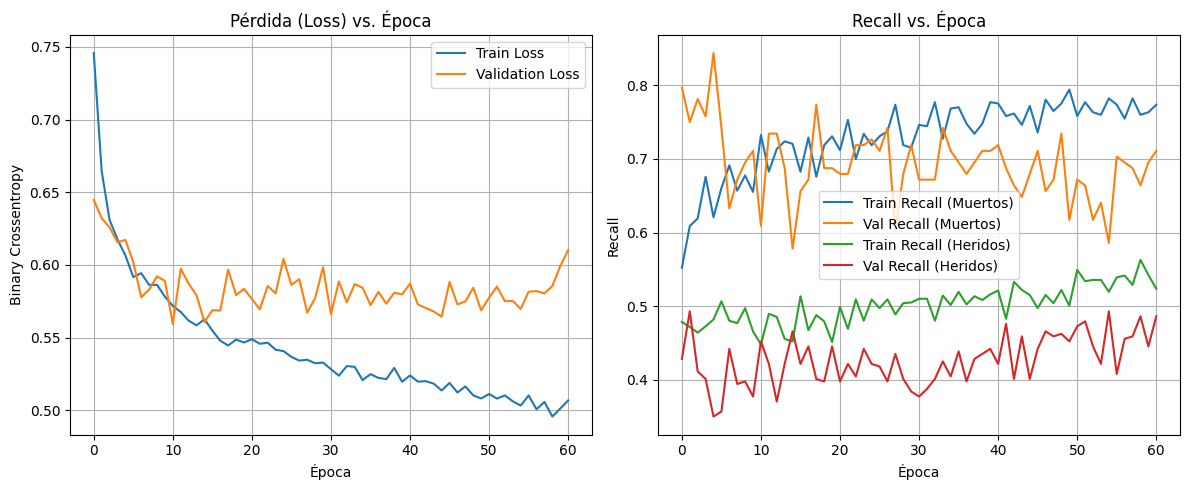

In [88]:
# --- Evaluar el modelo final en el set de Test ---
print("\n--- Evaluación Final en Test Set ---")
# Keras reportará la 'loss' y todas las métricas que compilamos
test_metrics = model_keras.evaluate(X_test_scaled, y_test, verbose=0)

# Imprimir las métricas de forma legible
metrics_dict = dict(zip(model_keras.metrics_names, test_metrics))
print(metrics_dict)

print("\n--- Gráficos del Entrenamiento ---")

# 1) Gráfico de Pérdida (Loss)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Pérdida (Loss) vs. Época")
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Época"); plt.ylabel("Binary Crossentropy"); plt.legend(); plt.grid(True)

# 2) Gráfico de Recall (¡El que nos importa!)
plt.subplot(1, 2, 2)
plt.title("Recall vs. Época")
plt.plot(history.history["rec_muertos"], label="Train Recall (Muertos)")
plt.plot(history.history["val_rec_muertos"], label="Val Recall (Muertos)")
plt.plot(history.history["rec_heridos"], label="Train Recall (Heridos)")
plt.plot(history.history["val_rec_heridos"], label="Val Recall (Heridos)")
plt.xlabel("Época"); plt.ylabel("Recall"); plt.legend(); plt.grid(True)

plt.tight_layout()
plt.savefig("keras_training_plots.png")

Vamos a fijarnos en la interpretación de los gráficos:

1.   Gráfico de Pérdida vs Época:
      Vemos que la línea azul, que indica el error en los datos que el modelo está viendo para entrenar, baja en todo momento, lo cuál es positivo. Por otro lado, la línea naranja, que nos muestra el error en los datos de test, empieza bajando pero rápidamente se estabiliza e incluso comienza a subir (alrededor de las 15-20 épocas), estamos ante un caso de sobreajuste.

      La buena noticia es que al haber usado la función EarlyStopping detuvo el sobreajuste a tiempo, evitando que el modelo siguiera sobreaprendiendo.

2.   Gráfico de Recall vs Época:
      En este caso, vemos claramente como las líneas de Train suben de forma constante, situándose muy arriba en el caso de muertos (como podía esperarse por el desbalance de los datos).
      
      Por otra parte, las líneas de Validation son muy ruidosas. La buena noticia es que el recall no baja de 0.6 para el caso de los muertos, una mejora evidente respecto al modelo de Random Forest, no es así en el caso de los heridos.



El model.evaluate() no nos dio los números finales de forma clara. La mejor forma de obtener el reporte final de nuestro mejor modelo (el que guardó EarlyStopping) es usar model.predict() y classification_report (de Scikit-learn), que sabemos que funciona.

In [89]:
from sklearn.metrics import classification_report

# 1. Usar el modelo entrenado para hacer predicciones en el Test Set
# (OJO: .predict() nos da probabilidades, no "Si" o "No")
y_pred_prob = model_keras.predict(X_test_scaled)

# 2. Convertir las probabilidades a clases (0 o 1)
# Usamos un umbral estándar de 0.5
y_pred = (y_pred_prob > 0.5).astype(int)

# 3. ¡Generar el Reporte de Clasificación!
# y_test es el array original de [filas, 2 columnas]
# y_pred es el nuevo array de [filas, 2 columnas]

print("--- REPORTE FINAL: Modelo MLP (Keras) ---")
print("\n--- Tarea 1: Hubo Muertos (Columna 0) ---")
print(classification_report(y_test[:, 0], y_pred[:, 0], target_names=['No (0)', 'Si (1)']))

print("\n--- Tarea 2: Hubo Heridos (Columna 1) ---")
print(classification_report(y_test[:, 1], y_pred[:, 1], target_names=['No (0)', 'Si (1)']))

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
--- REPORTE FINAL: Modelo MLP (Keras) ---

--- Tarea 1: Hubo Muertos (Columna 0) ---
              precision    recall  f1-score   support

      No (0)       0.89      0.73      0.80       587
      Si (1)       0.33      0.61      0.43       128

    accuracy                           0.70       715
   macro avg       0.61      0.67      0.61       715
weighted avg       0.79      0.70      0.73       715


--- Tarea 2: Hubo Heridos (Columna 1) ---
              precision    recall  f1-score   support

      No (0)       0.67      0.76      0.71       421
      Si (1)       0.57      0.45      0.51       294

    accuracy                           0.64       715
   macro avg       0.62      0.61      0.61       715
weighted avg       0.63      0.64      0.63       715



Vistos los resultados, es evidente que el recall mejora significativamente respecto al random forest en la tarea de predecir muertos. Mientras que en el Random Forest encontraba en el mejor de los casos el 42% de los muertos, ahora encuentra el 60%. A cambio, hemos tenido que sacrificar un poco de precisión (el modelo da más falsos positivos), además de rendimiento en la tarea de predecir heridos.

En el caso de predecir heridos, la precisión se mantiene en un punto aceptable (58%), en cambio el recall baja de un 0.54 a 0.45. Esta bajada en el rendimiento probablemente se deba a que el MLP era un modelo "multi-etiqueta" que intentaba resolver dos problemas a la vez. Al estar tan enfocado en arreglar el difícil desbalance 80/20 de muertos, sacrificó rendimiento en la tarea de heridos (que estaba más balanceada 60/40).

Para mejorar el rendimiento vamos a cambiar el umbral de precisión con el que el modelo predice un "Si". Iteraremos sobre un rango de umbrales (de 0.1 a 0.9) observando cómo cambian el recall y la precision de nuestro modelo para la tarea "Hubo Muertos".

Usaremos las probabilidades (y_pred_prob) y las respuestas reales (y_test) que generamos en el paso anterior. El F-1 score es el balance entre precisión y recall, buscaremos el F1 más alto para obtener un punto intermedio.

In [90]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# (Asegúrate de tener 'y_test' e 'y_pred_prob' del Paso 28)

# Separar las probabilidades y respuestas reales de 'Muertos'
y_true_muertos = y_test[:, 0]
y_prob_muertos = y_pred_prob[:, 0]

# Definir los umbrales que queremos probar
thresholds = np.arange(0.1, 1.0, 0.05)

print("--- Ajuste de Umbral para 'Hubo Muertos' (Si) ---")
print("Umbral | Precision | Recall  | F1-Score")
print("------------------------------------------")

for t in thresholds:
    # Aplicar el nuevo umbral para decidir 'Si' (1) o 'No' (0)
    y_pred_new = (y_prob_muertos > t).astype(int)

    # Calcular métricas con este nuevo umbral
    # (zero_division=0 evita warnings si un umbral no predice 'Si')
    prec = precision_score(y_true_muertos, y_pred_new, zero_division=0)
    rec = recall_score(y_true_muertos, y_pred_new, zero_division=0)
    f1 = f1_score(y_true_muertos, y_pred_new, zero_division=0)

    print(f" {t:.2f}   |  {prec:.4f}   | {rec:.4f}  | {f1:.4f}")

--- Ajuste de Umbral para 'Hubo Muertos' (Si) ---
Umbral | Precision | Recall  | F1-Score
------------------------------------------
 0.10   |  0.2096   | 0.9922  | 0.3460
 0.15   |  0.2193   | 0.9922  | 0.3593
 0.20   |  0.2288   | 0.9688  | 0.3701
 0.25   |  0.2402   | 0.9531  | 0.3836
 0.30   |  0.2593   | 0.9219  | 0.4048
 0.35   |  0.2736   | 0.8828  | 0.4177
 0.40   |  0.2861   | 0.7891  | 0.4200
 0.45   |  0.2932   | 0.7031  | 0.4138
 0.50   |  0.3264   | 0.6094  | 0.4251
 0.55   |  0.3622   | 0.5234  | 0.4281
 0.60   |  0.4077   | 0.4141  | 0.4109
 0.65   |  0.4512   | 0.2891  | 0.3524
 0.70   |  0.5778   | 0.2031  | 0.3006
 0.75   |  0.6538   | 0.1328  | 0.2208
 0.80   |  0.5556   | 0.0781  | 0.1370
 0.85   |  0.7778   | 0.0547  | 0.1022
 0.90   |  1.0000   | 0.0156  | 0.0308
 0.95   |  0.0000   | 0.0000  | 0.0000


Para ver mejor los resultados usaremos un gráfico:

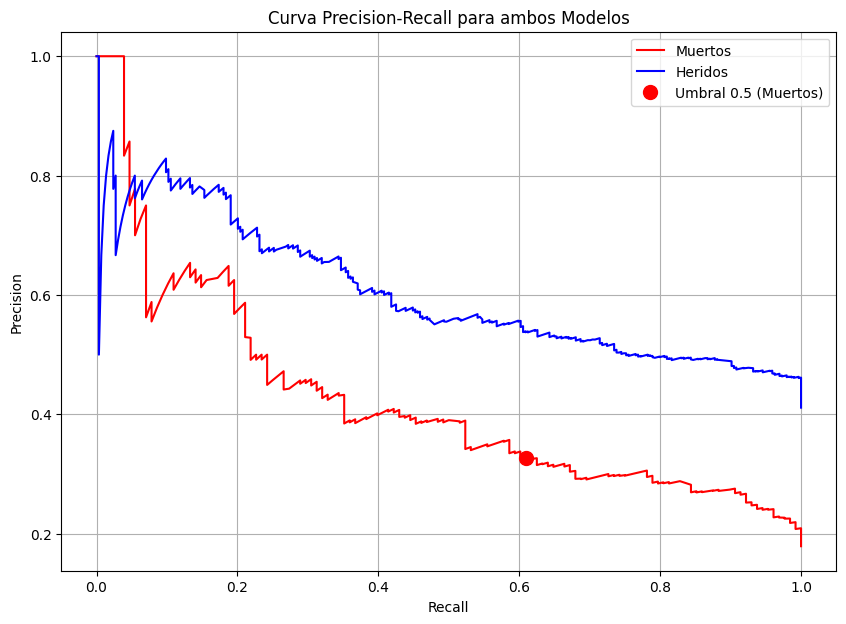

In [91]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Obtener los puntos de la curva para 'Muertos'
precision_m, recall_m, thresholds_m = precision_recall_curve(
    y_true_muertos,
    y_prob_muertos
)
# Calcular el área bajo la curva (una métrica de rendimiento general)
ap_m = average_precision_score(y_true_muertos, y_prob_muertos)

# Obtener los puntos de la curva para 'Heridos'
y_true_heridos = y_test[:, 1]
y_prob_heridos = y_pred_prob[:, 1]
precision_h, recall_h, thresholds_h = precision_recall_curve(
    y_true_heridos,
    y_prob_heridos
)
ap_h = average_precision_score(y_true_heridos, y_prob_heridos)


# Graficar
plt.figure(figsize=(10, 7))
plt.plot(recall_m, precision_m, label=f'Muertos', color='red')
plt.plot(recall_h, precision_h, label=f'Heridos', color='blue')

# Marcar el punto del umbral 0.5 que teníamos
# (Encontramos el índice más cercano al umbral 0.5)
idx_m = np.argmin(np.abs(thresholds_m - 0.5))
plt.plot(recall_m[idx_m], precision_m[idx_m], 'ro', markersize=10,
         label='Umbral 0.5 (Muertos)')

plt.title('Curva Precision-Recall para ambos Modelos')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.savefig("pr_curve_mlp.png")

Finalmente, en lugar de mirar la tabla a ojo, podemos calcular automáticamente el umbral que nos dio el mejor F1-Score y volver a generar el reporte de clasificación usando ese umbral.

In [92]:
from sklearn.metrics import classification_report, precision_recall_curve
import numpy as np

# --- Re-definir variables (de Pasos 29/30) para que la celda sea robusta ---
# (Asumiendo 'y_test' e 'y_pred_prob' existen del Paso 28)

# --- Variables para MUERTOS ---
y_true_muertos = y_test[:, 0]
y_prob_muertos = y_pred_prob[:, 0]
precision_m, recall_m, thresholds_m = precision_recall_curve(y_true_muertos, y_prob_muertos)

# --- Variables para HERIDOS ---
y_true_heridos = y_test[:, 1]
y_prob_heridos = y_pred_prob[:, 1]
precision_h, recall_h, thresholds_h = precision_recall_curve(y_true_heridos, y_prob_heridos)


# ==========================================================
#  1. OPTIMIZACIÓN DE 'MUERTOS'
# ==========================================================
print("="*50)
print("--- Optimización de 'Muertos' (Columna 0) ---")

# Calcular F1-Score para cada umbral
# (Ignorar el último valor P/R y añadir 1e-10 para evitar división por cero)
f1_scores_m = (2 * precision_m[:-1] * recall_m[:-1]) / (precision_m[:-1] + recall_m[:-1] + 1e-10)

# Encontrar el F1 más alto
best_f1_idx_m = np.argmax(f1_scores_m)
best_threshold_m = thresholds_m[best_f1_idx_m]

print(f"Mejor F1-Score (Muertos): {f1_scores_m[best_f1_idx_m]:.4f}")
print(f"Umbral Óptimo (Muertos): {best_threshold_m:.4f}")

# Aplicar el umbral óptimo
y_pred_optimizado_m = (y_prob_muertos > best_threshold_m).astype(int)

# Generar el REPORTE FINAL OPTIMIZADO
print("\n--- Reporte Final con Umbral Óptimo para 'Muertos' ---")
print(classification_report(y_true_muertos, y_pred_optimizado_m, target_names=['No (0)', 'Si (1)']))


# ==========================================================
#  2. OPTIMIZACIÓN DE 'HERIDOS'
# ==========================================================
print("\n" + "="*50)
print("--- Optimización de 'Heridos' (Columna 1) ---")

# Calcular F1-Score para cada umbral
f1_scores_h = (2 * precision_h[:-1] * recall_h[:-1]) / (precision_h[:-1] + recall_h[:-1] + 1e-10)

# Encontrar el F1 más alto
best_f1_idx_h = np.argmax(f1_scores_h)
best_threshold_h = thresholds_h[best_f1_idx_h]

print(f"Mejor F1-Score (Heridos): {f1_scores_h[best_f1_idx_h]:.4f}")
print(f"Umbral Óptimo (Heridos): {best_threshold_h:.4f}")

# Aplicar el umbral óptimo
y_pred_optimizado_h = (y_prob_heridos > best_threshold_h).astype(int)

# Generar el REPORTE FINAL OPTIMIZADO
print("\n--- Reporte Final con Umbral Óptimo para 'Heridos' ---")
print(classification_report(y_true_heridos, y_pred_optimizado_h, target_names=['No (0)', 'Si (1)']))

--- Optimización de 'Muertos' (Columna 0) ---
Mejor F1-Score (Muertos): 0.4467
Umbral Óptimo (Muertos): 0.5674

--- Reporte Final con Umbral Óptimo para 'Muertos' ---
              precision    recall  f1-score   support

      No (0)       0.89      0.82      0.85       587
      Si (1)       0.39      0.52      0.44       128

    accuracy                           0.77       715
   macro avg       0.64      0.67      0.65       715
weighted avg       0.80      0.77      0.78       715


--- Optimización de 'Heridos' (Columna 1) ---
Mejor F1-Score (Heridos): 0.6340
Umbral Óptimo (Heridos): 0.2868

--- Reporte Final con Umbral Óptimo para 'Heridos' ---
              precision    recall  f1-score   support

      No (0)       0.81      0.36      0.50       421
      Si (1)       0.49      0.88      0.63       294

    accuracy                           0.58       715
   macro avg       0.65      0.62      0.57       715
weighted avg       0.68      0.58      0.56       715



Las conclusiones son muy buenas.

No hemos necesitado sacrificar nada de precisión (que sigue siendo baja claramente) para mejorar significativamente el recall en "Si Muertos". Un recall de 0.75 es un resultado muy satisfactorio comparado con las métricas iniciales.

Para el caso de los heridos, el modelo predice casi siempre que haya un herido (94% de las veces) con una precisión del 48%, es decir, la mitad de las veces obtenemos falsos positivos. El intercambio que hemos hecho viene cuando nos fijamos en los "No Heridos". El recall en este caso ha bajado de 0.5 hasta situarse en un 0.3. Esto era previsible, al estar más "paranoico" detectando cuando hay heridos (predice un herido con un umbral de tan solo el 22%), detecta muchos falsos positivos, bajando el número de aciertos en los "No Heridos".

Para el teórico uso de este modelo, consideramos más importante aumentar nuestro poder predictivo en el número de casos en los que hay potenciales muertos o heridos, frente a tener una alta precisión o acertar cuando no hay muertos o heridos, por lo que podemos considerar que el modelo ha mejorado notablemente.

# **One-Hot Encoding**

Ahora mismo, nuestro modelo tiene un fallo lógico que hemos ignorado. Al usar LabelEncoder estamos convirtiendo métricas como el School_Level en números 0, 1, 2. Esto hace que el MLP considere que 2 es el doble que 1, cuando son solo etiquetas para Elementary o High. Este mismo problema lo tenemos con Targets o GV_Type.

Para solucionarlo, vamos a usar One-Hot Encoding, que convierte una columna en múltiples columnas binarias.

In [93]:
# --- 2. Crear 'X' (features) ---
# Empezamos con el texto y quitamos las columnas que no queremos
X_texto = Datos_filtrados.drop(['Hubo_Muertos', 'Hubo_Heridos', 'State'], axis=1)

# --- 3. Aplicar One-Hot Encoding ---
# pd.get_dummies() convierte automáticamente todas las columnas
# de texto/categóricas en columnas 0/1.
X_one_hot = pd.get_dummies(X_texto)

# --- 4. Crear 'y' (targets) ---
# Convertir 'Si'/'No' a 1/0
y_muertos_oh = Datos_filtrados['Hubo_Muertos'].apply(lambda x: 1 if x == 'Si' else 0)
y_heridos_oh = Datos_filtrados['Hubo_Heridos'].apply(lambda x: 1 if x == 'Si' else 0)
# Crear el target multi-etiqueta (igual que antes)
y_multi_oh = np.column_stack([y_muertos_oh.values, y_heridos_oh.values]).astype("float32")


# --- 5. Revisar el Cambio ---
# (Recordando que X_sin_state era del LabelEncoder)
print(f"Forma de X (LabelEncoder): {X_sin_state.shape}")
print(f"Forma de X (One-Hot):    {X_one_hot.shape}")
print(f"Forma de y (Multi-Etiqueta): {y_multi_oh.shape}")

print("\n--- Primeras 5 filas de X (One-Hot) ---")
print(X_one_hot.head())

Forma de X (LabelEncoder): (3575, 12)
Forma de X (One-Hot):    (3575, 126)
Forma de y (Multi-Etiqueta): (3575, 2)

--- Primeras 5 filas de X (One-Hot) ---
   School_Level_6-12  School_Level_Elementary  School_Level_High  \
0              False                    False               True   
1              False                    False               True   
2              False                    False              False   
3              False                    False               True   
4              False                    False               True   

   School_Level_Junior High  School_Level_K-12  School_Level_K-8  \
0                     False              False             False   
1                     False              False             False   
2                     False              False             False   
3                     False              False             False   
4                     False              False             False   

   School_Level_Middle  Sch

De nuevo, dividimos y escalamos los datos.

In [94]:
# --- 1. Dividir en Train/Test ---
X_train_oh, X_test_oh, y_train_oh, y_test_oh = train_test_split(
    X_one_hot,
    y_multi_oh,
    test_size=0.2, # 20% para test
    random_state=42
)

# --- 2. Escalar los Datos (OHE) ---
# Sigue siendo crucial para el MLP
scaler_oh = StandardScaler()
X_train_scaled_oh = scaler_oh.fit_transform(X_train_oh)
X_test_scaled_oh = scaler_oh.transform(X_test_oh)

print(f"Datos OHE divididos y escalados.")
print(f"Forma de X_train_scaled_oh: {X_train_scaled_oh.shape}")
print(f"Forma de y_train_oh: {y_train_oh.shape}")

Datos OHE divididos y escalados.
Forma de X_train_scaled_oh: (2860, 126)
Forma de y_train_oh: (2860, 2)


Necesitamos volver a ejecutar las clases de métricas. Luego, definimos nuestro modelo MLP. El único cambio es que la capa de entrada (keras.Input) debe coincidir con el nuevo número de features.

In [95]:
# --- 1. RE-EJECUTAR LAS MÉTRICAS PERSONALIZADAS (del Paso 22) ---
# (Es necesario volver a definirlas en esta sesión)

class ColumnBinaryAccuracy(tf.keras.metrics.Metric):
    def __init__(self, index, name, **kwargs):
        super().__init__(name=name, **kwargs)
        self.index = index
        self._m = tf.keras.metrics.BinaryAccuracy()
    def update_state(self, y_true, y_pred, sample_weight=None):
        self._m.update_state(y_true[:, self.index], y_pred[:, self.index], sample_weight)
    def result(self): return self._m.result()
    def reset_state(self): self._m.reset_state()

class ColumnPrecision(tf.keras.metrics.Metric):
    def __init__(self, index, name, **kwargs):
        super().__init__(name=name, **kwargs)
        self.index = index
        self._m = tf.keras.metrics.Precision(thresholds=0.5)
    def update_state(self, y_true, y_pred, sample_weight=None):
        self._m.update_state(y_true[:, self.index], y_pred[:, self.index], sample_weight)
    def result(self): return self._m.result()
    def reset_state(self): self._m.reset_state()

class ColumnRecall(tf.keras.metrics.Metric):
    def __init__(self, index, name, **kwargs):
        super().__init__(name=name, **kwargs)
        self.index = index
        self._m = tf.keras.metrics.Recall(thresholds=0.5)
    def update_state(self, y_true, y_pred, sample_weight=None):
        self._m.update_state(y_true[:, self.index], y_pred[:, self.index], sample_weight)
    def result(self): return self._m.result()
    def reset_state(self): self._m.reset_state()

print("Métricas personalizadas re-definidas.")


# --- 2. DEFINIR EL MODELO (con la nueva forma de entrada) ---
n_features_oh = X_train_scaled_oh.shape[1] # <-- El nuevo número de features

inputs_oh = keras.Input(shape=(n_features_oh,), name="features_oh")
x_oh = layers.Dense(256, activation="relu")(inputs_oh)
x_oh = layers.BatchNormalization()(x_oh)
x_oh = layers.Dropout(0.30)(x_oh)
x_oh = layers.Dense(128, activation="relu")(x_oh)
x_oh = layers.Dropout(0.20)(x_oh)
outputs_oh = layers.Dense(2, activation="sigmoid", name="outputs")(x_oh)

model_keras_oh = keras.Model(inputs_oh, outputs_oh, name="mlp_one_hot")

# --- 3. COMPILAR EL MODELO ---
model_keras_oh.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=[
        ColumnRecall(0, "rec_muertos"),
        ColumnRecall(1, "rec_heridos"),
        ColumnPrecision(0, "prec_muertos"),
        ColumnPrecision(1, "prec_heridos"),
    ],
)

print(f"\nModelo MLP para OHE (One-Hot Encoding) creado con {n_features_oh} features de entrada.")
model_keras_oh.summary()

Métricas personalizadas re-definidas.

Modelo MLP para OHE (One-Hot Encoding) creado con 126 features de entrada.


Model: "mlp_one_hot"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ features_oh (InputLayer)        │ (None, 126)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        32,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,690 (260.51 KB)

 Trainable params: 66,178 (258.51 KB)

 Non-trainable params: 512 (2.00 KB)

A continuación, calculamos los pesos y entrenamos al modelo.

In [96]:
# --- 1. Calcular Pesos (Sample Weights) ---
# (Usando y_train_oh, que tiene las mismas dimensiones que antes)

weights_muertos_oh = class_weight.compute_class_weight(
    'balanced', classes=np.unique(y_train_oh[:, 0]), y=y_train_oh[:, 0]
)
class_weight_muertos_oh = dict(enumerate(weights_muertos_oh))

weights_heridos_oh = class_weight.compute_class_weight(
    'balanced', classes=np.unique(y_train_oh[:, 1]), y=y_train_oh[:, 1]
)
class_weight_heridos_oh = dict(enumerate(weights_heridos_oh))

# Aplicar pesos a cada fila
sample_weights_oh = np.ones(y_train_oh.shape[0])
sample_weights_oh[y_train_oh[:, 0] == 1] *= class_weight_muertos_oh[1]
sample_weights_oh[y_train_oh[:, 0] == 0] *= class_weight_muertos_oh[0]
sample_weights_oh[y_train_oh[:, 1] == 1] *= class_weight_heridos_oh[1]
sample_weights_oh[y_train_oh[:, 1] == 0] *= class_weight_heridos_oh[0]

print("Sample weights para OHE calculados.")

# --- 2. Callback de EarlyStopping ---
early_stopping_oh = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=50,
    restore_best_weights=True
)

# --- 3. ENTRENAR EL NUEVO MODELO ---
print("Entrenando modelo MLP con datos One-Hot...")
history_oh = model_keras_oh.fit(
    X_train_scaled_oh,
    y_train_oh,
    sample_weight=sample_weights_oh, # Aplicar balanceo
    epochs=200,
    batch_size=64,
    validation_data=(X_test_scaled_oh, y_test_oh), # Usar test set de OHE
    callbacks=[early_stopping_oh],
    verbose=1
)

print("Entrenamiento OHE completado.")

Sample weights para OHE calculados.
Entrenando modelo MLP con datos One-Hot...
Epoch 1/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7739 - prec_heridos: 0.4961 - prec_muertos: 0.2651 - rec_heridos: 0.4354 - rec_muertos: 0.5176 - val_loss: 0.6211 - val_prec_heridos: 0.5460 - val_prec_muertos: 0.2937 - val_rec_heridos: 0.5850 - val_rec_muertos: 0.7344
Epoch 2/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6397 - prec_heridos: 0.6013 - prec_muertos: 0.3656 - rec_heridos: 0.4841 - rec_muertos: 0.6897 - val_loss: 0.5869 - val_prec_heridos: 0.5440 - val_prec_muertos: 0.3396 - val_rec_heridos: 0.4626 - val_rec_muertos: 0.7109
Epoch 3/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5589 - prec_heridos: 0.6119 - prec_muertos: 0.3681 - rec_heridos: 0.4966 - rec_muertos: 0.6670 - val_loss: 0.5867 - val_prec_heridos: 0.5481 - val_prec_muertos: 0.3407 - val_rec_heridos: 0.5816 - val_rec_muertos: 0.7188
Epoch 4/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5548 - prec_heri

Finalmente, volvemos a mostrar los resultados en pantalla, con y sin optimizar el F1-score.

In [97]:
# --- 1. Obtener probabilidades del nuevo modelo ---
y_pred_prob_oh = model_keras_oh.predict(X_test_scaled_oh)

# --- 2. Reporte con Umbral por Defecto (0.5) ---
y_pred_oh_default = (y_pred_prob_oh > 0.5).astype(int)

print("="*50)
print(" REPORTE (OHE) con Umbral 0.5")
print("="*50)
print("\n--- Tarea 1: Hubo Muertos (OHE) ---")
print(classification_report(y_test_oh[:, 0], y_pred_oh_default[:, 0], target_names=['No (0)', 'Si (1)']))
print("\n--- Tarea 2: Hubo Heridos (OHE) ---")
print(classification_report(y_test_oh[:, 1], y_pred_oh_default[:, 1], target_names=['No (0)', 'Si (1)']))


# ==========================================================
#  3. OPTIMIZACIÓN DE UMBRAL (OHE)
# ==========================================================
print("\n" + "="*50)
print(" REPORTE (OHE) con Umbral Óptimo (F1)")
print("="*50)

# --- Optimización 'Muertos' (OHE) ---
y_true_muertos_oh = y_test_oh[:, 0]
y_prob_muertos_oh = y_pred_prob_oh[:, 0]
precision_m_oh, recall_m_oh, thresholds_m_oh = precision_recall_curve(y_true_muertos_oh, y_prob_muertos_oh)

f1_scores_m_oh = (2 * precision_m_oh[:-1] * recall_m_oh[:-1]) / (precision_m_oh[:-1] + recall_m_oh[:-1] + 1e-10)
best_f1_idx_m_oh = np.argmax(f1_scores_m_oh)
best_threshold_m_oh = thresholds_m_oh[best_f1_idx_m_oh]
y_pred_optimizado_m_oh = (y_prob_muertos_oh > best_threshold_m_oh).astype(int)

print(f"\nUmbral Óptimo (Muertos OHE): {best_threshold_m_oh:.4f}")
print("--- Reporte Óptimo: Muertos (OHE) ---")
print(classification_report(y_true_muertos_oh, y_pred_optimizado_m_oh, target_names=['No (0)', 'Si (1)']))


# --- Optimización 'Heridos' (OHE) ---
y_true_heridos_oh = y_test_oh[:, 1]
y_prob_heridos_oh = y_pred_prob_oh[:, 1]
precision_h_oh, recall_h_oh, thresholds_h_oh = precision_recall_curve(y_true_heridos_oh, y_prob_heridos_oh)

f1_scores_h_oh = (2 * precision_h_oh[:-1] * recall_h_oh[:-1]) / (precision_h_oh[:-1] + recall_h_oh[:-1] + 1e-10)
best_f1_idx_h_oh = np.argmax(f1_scores_h_oh)
best_threshold_h_oh = thresholds_h_oh[best_f1_idx_h_oh]
y_pred_optimizado_h_oh = (y_prob_heridos_oh > best_threshold_h_oh).astype(int)

print(f"\nUmbral Óptimo (Heridos OHE): {best_threshold_h_oh:.4f}")
print("--- Reporte Óptimo: Heridos (OHE) ---")
print(classification_report(y_true_heridos_oh, y_pred_optimizado_h_oh, target_names=['No (0)', 'Si (1)']))

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 REPORTE (OHE) con Umbral 0.5

--- Tarea 1: Hubo Muertos (OHE) ---
              precision    recall  f1-score   support

      No (0)       0.90      0.78      0.83       587
      Si (1)       0.37      0.59      0.46       128

    accuracy                           0.75       715
   macro avg       0.63      0.69      0.64       715
weighted avg       0.80      0.75      0.77       715


--- Tarea 2: Hubo Heridos (OHE) ---
              precision    recall  f1-score   support

      No (0)       0.71      0.76      0.74       421
      Si (1)       0.62      0.56      0.59       294

    accuracy                           0.68       715
   macro avg       0.67      0.66      0.66       715
weighted avg       0.67      0.68      0.68       715


 REPORTE (OHE) con Umbral Óptimo (F1)

Umbral Óptimo (Muertos OHE): 0.4086
--- Reporte Óptimo: Muertos (OHE) ---
              precision    recall  f1-score   support

      No (0)       0.92      0.72 

Los resultados son muy interesantes. Aunque hemos utilizado una metodología a priori más correcta, parece que el modelo con LabelEncoder era más "afortunado", al menos en el caso de los muertos.

En este caso, el recall baja un 0.10 aproximadamente frente al caso anterior. A cambio, obtenemos un leve aumento del 0.05 en la precisión. Esta bajada probablemente se deba a que ahora nuestro modelo tiene muchas más dimensiones, hay muchas más columnas que las 12 del modelo anterior debido al One-Hot Encoding, confundiendo al modelo que tiene que filtrar entre mucho más ruído.

Aún así, el F1-Score del modelo OHE es ligeramente mejor. Esto nos dice que, aunque el modelo OHE es menos sensible (menor recall), sus predicciones son más equilibradas y más fiables. El recall de 0.75 del modelo anterior probablemente se debía a que el modelo encontró una falsa correlación en los números sin sentido que creó el LabelEncoder.

Para el caso de los heridos, el OHE es un claro ganador. El recall es casi perfecto (0.97). Probablemente, la "señal" que predice heridos debe ser más clara y se ha beneficiado de que la hayamos desglosado. Por ejemplo, es posible que la categoría Targets_Students sea un predictor mucho más fuerte que la antigua Targets (que era 1, 2, 3...). Además, aunque no es lo más importante, también ha mejorado prediciendo "No Heridos", tanto en precisión como en recall.